In [19]:
import numpy as np
import os.path
import pickle
import pandas as pd
import torch
import matplotlib.pyplot as plt
import requests
import networkx as nx
from geopy import distance
from geopy.distance import lonlat
import random 
from collections import Counter
import dateutil
from dateutil.relativedelta import relativedelta
from requests import HTTPError
from obspy import UTCDateTime
from urllib3.exceptions import ProtocolError
import datetime
import time
from sklearn.metrics import pairwise_distances

import os
os.environ["PROJ_LIB"] = "C:\\Users\\gabri\\AppData\\Local\\Continuum\\anaconda3\\pkgs\\proj4-5.2.0-ha925a31_1\\Library\\share";
from mpl_toolkits.basemap import Basemap

import sys
sys.path.append("../../../../..")
from definitions import QUAKES_RAW_DATA_PATH
from earthquakes.quakes_util import custom_geo_distance, is_point_in_bbox, get_earthquakes_in_timespan, find_closest_station, UTCDateTime_to_string, \
    string_to_UTCDateTime, quake_filename_to_UTCDateTime, BadDataException, read_pickle, write_pickle, obtain_data, timeit_context, visualize_sensors_graph, \
    create_weighted_adjacency_quakes, visualize_quakes, resample_data
from utils.misc_utils import check_create_folder



----------------------------

In [20]:
NEW_DATASET_FOLDER = os.path.join(QUAKES_RAW_DATA_PATH, "new_dataset_gabriele")
image_folder = os.path.join(NEW_DATASET_FOLDER, "images")
check_create_folder(NEW_DATASET_FOLDER)
check_create_folder(image_folder)

----------------------------

------------------------------------

C:\Users\gabri\AppData\Local\Continuum\anaconda3\envs\tud_ml4se\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


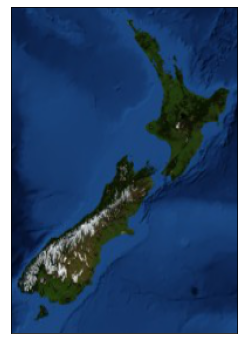

In [56]:
# taken from https://www.openstreetmap.org/export
bounding_box = [
    166.104, # left lower corner longitude
    178.990, # upper right corner longitude
    -47.749, # left lower corner latitude
    -33.779, # upper right corner latitude
]

nz_basemap = Basemap(
        projection='merc',
        llcrnrlon=bounding_box[0],  # left lower corner longitude
        llcrnrlat=bounding_box[2],  # left lower corner latitude
        urcrnrlon=bounding_box[1],
        urcrnrlat=bounding_box[3],
        lat_ts=0,
        resolution='f',
        suppress_ticks=True)

plt.figure(figsize=(6, 6))
nz_basemap.bluemarble()
plt.savefig(os.path.join(image_folder, "nz_bbox_map.pdf"))
plt.show()

----------------------------

----------------------------

---------------------

# Analysis of the stations to use and graph creation

In [22]:
stations_data = pd.read_csv(os.path.join(QUAKES_RAW_DATA_PATH, "filtered_stations.csv"), header=None, parse_dates=True)
station_coordinates = list(zip(stations_data[3], stations_data[4]))

stations_to_drop = []
for station_idx, station_point in enumerate(station_coordinates):
    if not is_point_in_bbox(station_point, bounding_box):
        stations_to_drop.append(station_idx)
del station_coordinates
print(f"Stations to drop (outside chosen bounding box): {stations_to_drop}")

stations_in_bbox = stations_data.drop(stations_to_drop)
station_coordinates = list(zip(stations_in_bbox[3], stations_in_bbox[4]))
print(f"New number of stations: {stations_in_bbox.shape[0]}")
assert len(station_coordinates) == 58

stations_in_bbox.head()

Stations to drop (outside chosen bounding box): [4]
New number of stations: 58


0   1                      2         3        4                5
0   BFZ  10  Broadband Seismometer  176.2462 -40.6796   7/30/2003 1:00
1   BHW  10  Broadband Seismometer  174.8711 -41.4082  7/14/2016 22:30
2   BKZ  10  Broadband Seismometer  176.4925 -39.1657  2/10/2004 21:00
3  COVZ  10  Broadband Seismometer  175.5424 -39.1999  11/1/2009 18:31
5   CVZ  10  Broadband Seismometer  171.0061 -44.3831  5/15/2014 20:00

In [23]:
STATIONS_QUERY = "https://service.geonet.org.nz/fdsnws/station/1/query?network=NZ&station={}&minlat=-47.749&maxlat=-33.779&minlon=166.104&maxlon=178.990&endafter=2020-01-01T12:00:00.000&format=text"
string_to_add = ",".join(stations_in_bbox[0].values)
response = requests.get(STATIONS_QUERY.format(string_to_add))

lines = response.text.split("\n")
names = lines[0].split(" | ")

stations_metadata = []
for line in lines[1:]:
    station_dict = {name.lower().strip(): value for name, value in zip(names, line.split("|"))}
    if len(station_dict) == len(names):
        stations_metadata.append(station_dict)
        
for idx, station_name in enumerate(stations_in_bbox[0].values):
    assert stations_metadata[idx]['station'] == station_name
    
del stations_in_bbox

stations_in_bbox_df = pd.DataFrame(stations_metadata)
stations_in_bbox_df.latitude = stations_in_bbox_df.latitude.astype(float)
stations_in_bbox_df.longitude = stations_in_bbox_df.longitude.astype(float)
stations_in_bbox_df.head()


#network station   latitude   longitude    elevation             sitename  \
0       NZ     BFZ -40.679647  176.246245   283.000000           Birch Farm   
1       NZ     BHW -41.408231  174.871115   101.000000          Baring Head   
2       NZ     BKZ -39.165666  176.492544   706.000000     Black Stump Farm   
3       NZ    COVZ -39.199914  175.542402  1133.000000  Chateau Observatory   
4       NZ     CVZ -44.383180  171.006160   454.000000                 Cave   

             starttime endtime  
0  1996-04-03T00:00:00          
1  1975-11-27T00:00:00          
2  2004-02-11T00:00:00          
3  1998-03-25T00:00:00          
4  2014-05-16T00:00:00

In [24]:
# stations_in_bbox_df.drop(['starttime', 'endtime', "elevation"], axis=1).to_latex()

## Graph creation

https://arxiv.org/pdf/2001.00267.pdf : "We select thresholds based on the cosine similarity that lead to an average degree of 10 for each graph"

Found multiplier: 0.3461
Threshold is 170.28509 kilometers.
Average degree: 10.0


C:\Users\gabri\AppData\Local\Continuum\anaconda3\envs\tud_ml4se\lib\site-packages\ipykernel_launcher.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


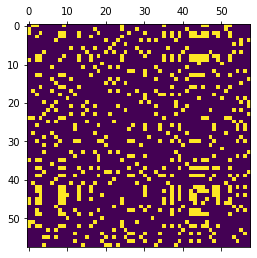

In [57]:
desired_average_degree = 10.0

station_lats=list(stations_in_bbox_df.latitude.values)
station_lons=list(stations_in_bbox_df.longitude.values)

station_coordinates = list(zip(station_lons, station_lats))  # lon - lat
all_distances = pairwise_distances(station_coordinates, station_coordinates, metric=custom_geo_distance)
assert all_distances.shape[0] == 58

mean_distance = np.mean(all_distances)
std_distance = np.std(all_distances)

for multiplier in np.arange(0.0, 1.0, 0.0001):
    multiplier = round(multiplier, 5)
    thres = mean_distance * multiplier
    
    adjacency = all_distances.copy()
    adjacency[adjacency <= thres] = 1
    adjacency[adjacency > thres] = 0
    
    adjacency = adjacency - np.eye(adjacency.shape[0])

    graph = nx.from_numpy_array(adjacency)
    graph_average_degree = np.mean([item[1] for item in nx.degree(graph)])
    
    if abs(desired_average_degree - graph_average_degree) < 0.01:
        print(f"Found multiplier: {multiplier}")
        print(f"Threshold is {round(thres, 5)} kilometers.")
        break



print(f"Average degree: {round(graph_average_degree, 2)}")

plt.matshow(adjacency)
plt.tight_layout()
plt.savefig(os.path.join(image_folder, "adjacency_matrix_nz.pdf"))
plt.show()

### Gaussian Kernel for edge weighting

Average distance of connected nodes: 108.654 kilometers.


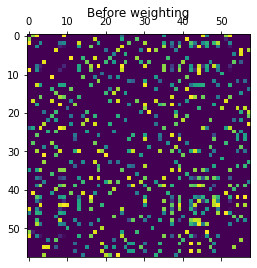

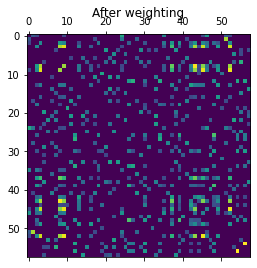

In [26]:
adjacency_matrix, weighted_adjacency = create_weighted_adjacency_quakes(all_distances, threshold=thres)

plt.matshow(adjacency_matrix)
plt.title("Before weighting")
plt.show()

plt.matshow(weighted_adjacency)
plt.title("After weighting")
plt.show()

# for i in range(adjacency_matrix.shape[0]):
#     for j in range(adjacency_matrix.shape[1]):
#         if adjacency_matrix[i, j]:
#             print(f"{adjacency_matrix[i, j]} --> {weighted_adjacency[i, j]}")


stations_in_bbox_df.to_csv(os.path.join(NEW_DATASET_FOLDER, "stations_in_bbox.csv"), header=True, index=True)


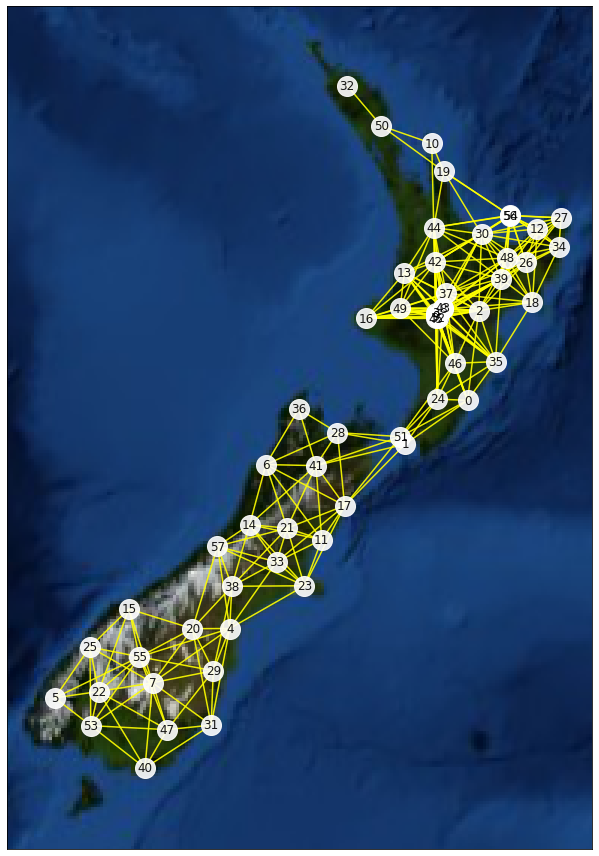

In [58]:
plt.figure(figsize=(12, 12))
visualize_sensors_graph(station_lons, station_lats, weighted_adjacency, 
                        nz_basemap, nodesize=400, nodecolor='white', 
                        draw_edges=True, edgecolors='yellow', with_labels=True,
                       alpha=0.9, width=1.5)
plt.tight_layout()
plt.savefig(os.path.join(image_folder, "graph_on_map_nz.pdf"))
plt.show()

In [28]:
NEW_DATASET_FOLDER

'C:\\Users\\gabri\\Desktop\\new_thesis_project\\earthquakes\\data\\new_dataset_gabriele'

In [29]:
np.save(os.path.join(NEW_DATASET_FOLDER, "packaged", "adjacency.npy"), adjacency_matrix)
np.save(os.path.join(NEW_DATASET_FOLDER, "packaged", "weighted_adjacency.npy"), weighted_adjacency)
np.save(os.path.join(NEW_DATASET_FOLDER, "packaged", "pairwise_distances.npy"), all_distances)

----------------------------

----------------------------

----------------------------

# Get and save the earthquakes metadata

The API seems to work only for request shorter than three months. Therefore, we have to query multiple times to cover longer horizons

In [30]:
CRAWL_NEW_DATA = True

if CRAWL_NEW_DATA:
    # we query the web service to get the data
    
    CRAWLING_START_DATE = dateutil.parser.parse("2016-01-01T00:00:00.000")
    CRAWLING_STEPS = 6 * 5
    MONTHS_PER_STEP = 2

    min_long = bounding_box[0]
    max_long = bounding_box[1]
    min_lat = bounding_box[2]
    max_lat = bounding_box[3]


    all_quakes_dictionaries = []

    start = CRAWLING_START_DATE
    for i in range(CRAWLING_STEPS):
        end = start + relativedelta(months=MONTHS_PER_STEP)
        start_iso = start.isoformat().strip()
        end_iso = end.isoformat().strip()

        print(f"Step: {i + 1} | start: {start_iso} | end: {end_iso}")    
        url_to_query = f"https://service.geonet.org.nz/fdsnws/event/1/query?format=text&start={start_iso}&end={end_iso}&minlat={min_lat}&maxlat={max_lat}&minlon={min_long}&maxlon={max_long}"
        all_quakes_dictionaries += get_earthquakes_in_timespan(url_to_query)

        print("Cumulative n. of earthquakes: ", len(all_quakes_dictionaries))
        start = end

    n_of_earthquakes = len(all_quakes_dictionaries)
    print(f"{n_of_earthquakes} earthquakes detected in total")


    quakes_df = pd.DataFrame(all_quakes_dictionaries)
    print(f"{quakes_df.shape[0]} earthquakes found.")
else:
    # we read the quake metadata from file
    quakes_df = pd.read_csv(os.path.join(NEW_DATASET_FOLDER, "quakes_metadata_in_bbox.csv"))
    print(f"{quakes_df.shape[0]} earthquakes found.")

Step: 1 | start: 2016-01-01T00:00:00 | end: 2016-03-01T00:00:00
Cumulative n. of earthquakes:  3461
Step: 2 | start: 2016-03-01T00:00:00 | end: 2016-05-01T00:00:00
Cumulative n. of earthquakes:  7060
Step: 3 | start: 2016-05-01T00:00:00 | end: 2016-07-01T00:00:00
Cumulative n. of earthquakes:  10035
Step: 4 | start: 2016-07-01T00:00:00 | end: 2016-09-01T00:00:00
Cumulative n. of earthquakes:  12792
Step: 5 | start: 2016-09-01T00:00:00 | end: 2016-11-01T00:00:00
Cumulative n. of earthquakes:  16998
Step: 6 | start: 2016-11-01T00:00:00 | end: 2017-01-01T00:00:00
Cumulative n. of earthquakes:  16998
Step: 7 | start: 2017-01-01T00:00:00 | end: 2017-03-01T00:00:00
Cumulative n. of earthquakes:  23262
Step: 8 | start: 2017-03-01T00:00:00 | end: 2017-05-01T00:00:00
Cumulative n. of earthquakes:  29409
Step: 9 | start: 2017-05-01T00:00:00 | end: 2017-07-01T00:00:00
Cumulative n. of earthquakes:  34362
Step: 10 | start: 2017-07-01T00:00:00 | end: 2017-09-01T00:00:00
Cumulative n. of earthquakes

In [31]:
quakes_df.magnitude = quakes_df.magnitude.astype(float)
quakes_df['latitude'] = quakes_df['latitude'].astype(float)
quakes_df['longitude'] = quakes_df['longitude'].astype(float)
quakes_df['depth/km'] = quakes_df['depth/km'].astype(float)

quakes_df.head(2)

#eventid                 time  latitude  longitude  depth/km author  \
0  2016p139705  2016-02-21T16:34:54   -41.595    174.316      15.1    GNS   
1  2016p139326  2016-02-21T13:13:27   -38.419    176.516     120.3    GNS   

  catalog contributor contributorid magtype  magnitude magauthor  \
0     GNS         GNS   2016p139705       M        2.0       GNS   
1     GNS         GNS   2016p139326       M        1.8       GNS   

        eventlocationname  
0    20 km east of Seddon  
1  15 km west of Murupara

----------------------------

----------------------------

----------------------------

# Visualizations of quakes

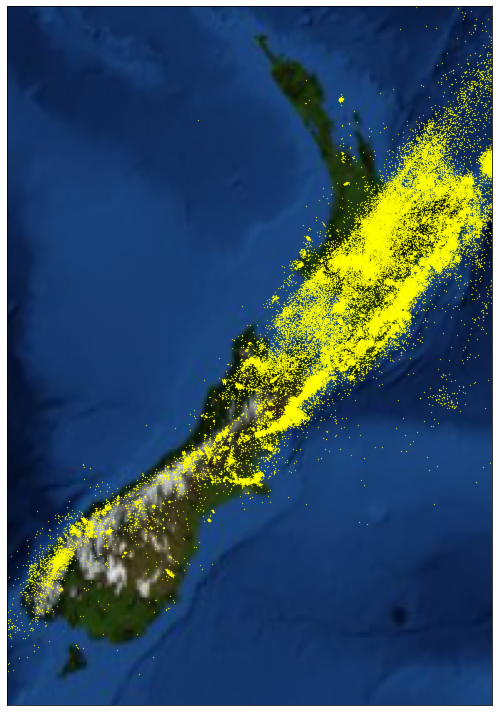

'C:\\Users\\gabri\\Desktop\\new_thesis_project\\earthquakes\\data\\new_dataset_gabriele\\images'

In [54]:
quakes_latitudes=list(quakes_df['latitude'].values)
quakes_longitudes=list(quakes_df['longitude'].values)

plt.figure(figsize=(10, 10))
visualize_quakes(quakes_longitudes, quakes_latitudes, nz_basemap, nodesize=0.1, nodecolor="yellow", alpha=0.9, title="")
plt.tight_layout()
plt.savefig(os.path.join(image_folder, "all_quakes.pdf"))
plt.show()
image_folder

### Let's look at the histogram of the magnitudes

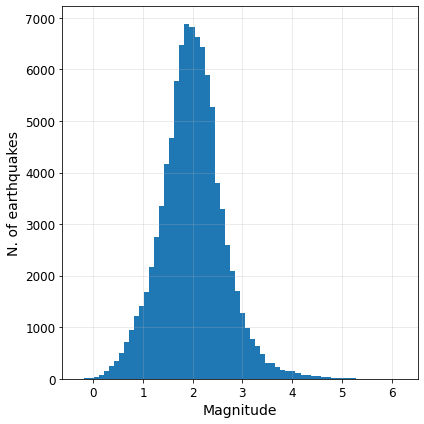

Minimum magnitude found: -0.3, Maximum magnitude found: 6.2


In [60]:
figsize = (6, 6)

plt.figure(figsize=figsize)
quakes_df.magnitude.sort_values().hist(bins=64)
plt.grid(alpha=0.3)
plt.xlabel("Magnitude", fontsize=14)
plt.ylabel("N. of earthquakes", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(image_folder, "all_quakes_magnitudes.pdf"))
plt.show()

print(f"Minimum magnitude found: {quakes_df.magnitude.min()}, Maximum magnitude found: {quakes_df.magnitude.max()}")

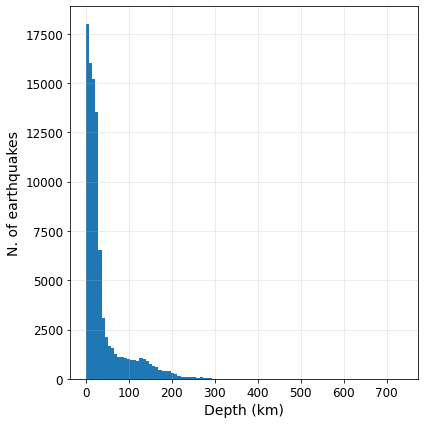

Minimum distance found: 0.0, Maximum distance found: 734.9


In [61]:
figsize = (6, 6)

plt.figure(figsize=figsize)
quakes_df['depth/km'].sort_values().hist(bins=100)
plt.grid(alpha=0.3)
plt.xlabel("Depth (km)", fontsize=14)
plt.ylabel("N. of earthquakes", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.ylim(0, None)
plt.savefig(os.path.join(image_folder, "all_quakes_depth.pdf"))

plt.show()

print(f"Minimum distance found: {quakes_df['depth/km'].min()}, Maximum distance found: {quakes_df['depth/km'].max()}")

In [35]:
image_folder

'C:\\Users\\gabri\\Desktop\\new_thesis_project\\earthquakes\\data\\new_dataset_gabriele\\images'

-------------------

-------------------

-------------------

## Let's filter the quakes based on the magnitudes

In [36]:
minimum_magnitude = 1
maximum_magnitude = 3.5

In [37]:
magn_filtered_quakes_df = quakes_df[
    (quakes_df['magnitude'].astype(float) >= minimum_magnitude)
    &
    (quakes_df['magnitude'].astype(float) <= maximum_magnitude)
].copy()

print(f"Obtained {magn_filtered_quakes_df.shape[0]} quakes out of {quakes_df.shape[0]} available. Min magn: {minimum_magnitude}, Max magn: {maximum_magnitude}")

Obtained 88353 quakes out of 94098 available. Min magn: 1, Max magn: 3.5


In [53]:
filtered_dataset_df = magn_filtered_quakes_df[magn_filtered_quakes_df['depth/km'].astype(float) <= 200]
filtered_dataset_df.shape[0]

87131

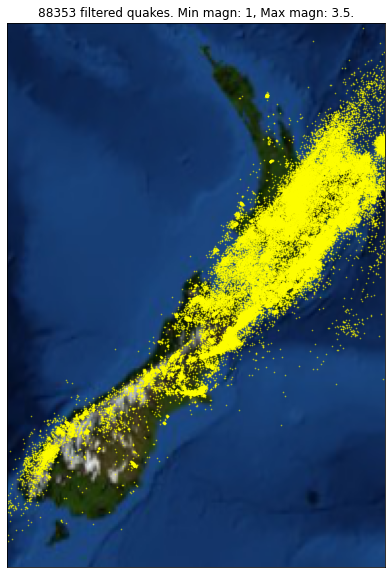

In [38]:
quakes_latitudes=list(magn_filtered_quakes_df['latitude'].astype(float).values)
quakes_longitudes=list(magn_filtered_quakes_df['longitude'].astype(float).values)
title = f"{magn_filtered_quakes_df.shape[0]} filtered quakes. Min magn: {minimum_magnitude}, Max magn: {maximum_magnitude}."

plt.figure(figsize=(10, 10))
visualize_quakes(quakes_longitudes, quakes_latitudes, nz_basemap, nodesize=0.5, nodecolor="yellow", alpha=0.5, title=title)
plt.show()

-------------------

-------------------

-------------------

## Assigning closest station to each quake (time consuming)

We only operate on the earthquakes already filtered by the magnitude, so we process less data

In [39]:
# TIME CONSUMING IF THERE ARE A LOT OF QUAKES
magn_filtered_quakes_df[['label', 'min_distance']]= magn_filtered_quakes_df.apply(lambda row: find_closest_station((row['longitude'], row['latitude']), station_coordinates), axis=1, result_type="expand")
magn_filtered_quakes_df.head(2)

#eventid                 time  latitude  longitude  depth/km author  \
0  2016p139705  2016-02-21T16:34:54   -41.595    174.316      15.1    GNS   
1  2016p139326  2016-02-21T13:13:27   -38.419    176.516     120.3    GNS   

  catalog contributor contributorid magtype  magnitude magauthor  \
0     GNS         GNS   2016p139705       M        2.0       GNS   
1     GNS         GNS   2016p139326       M        1.8       GNS   

        eventlocationname  label  min_distance  
0    20 km east of Seddon    1.0     50.679402  
1  15 km west of Murupara   39.0     45.938905

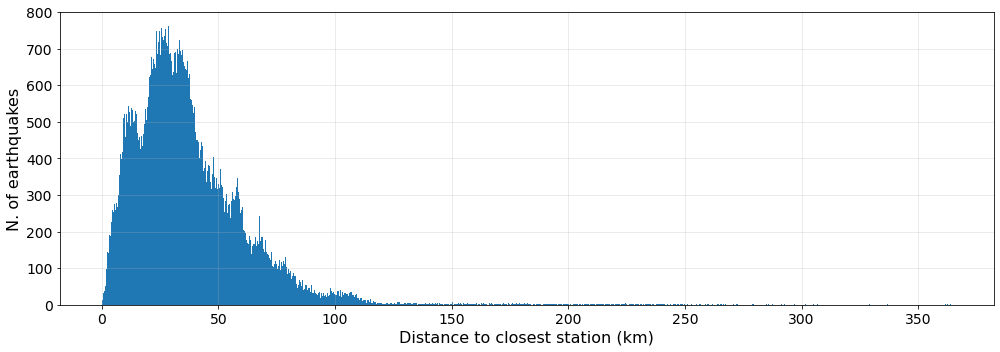

In [62]:
# plt.figure(figsize=(18, 2))
# magn_filtered_quakes_df.min_distance.astype(float).plot.density()
# plt.show()

plt.figure(figsize=(14, 5))
magn_filtered_quakes_df.min_distance.astype(float).sort_values().hist(bins=1000)

plt.grid(alpha=0.3)
plt.xlabel("Distance to closest station (km)", fontsize=16)
plt.ylabel("N. of earthquakes", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.ylim(0, None)
plt.savefig(os.path.join(image_folder, "minimum_distance_from_station.pdf"))


plt.show()

----------------------

----------------------

----------------------

# Filtering quakes based on distance to closest station

In [41]:
maximum_distance = 75  # kilometers

In [42]:
magn_distance_filtered_quakes_df = magn_filtered_quakes_df[
    magn_filtered_quakes_df['min_distance'].astype(float) <= maximum_distance
].copy()

print(f"Obtained {magn_distance_filtered_quakes_df.shape[0]} quakes from {magn_filtered_quakes_df.shape[0]}.") 

Obtained 82493 quakes from 88353.


----------------------

----------------------

----------------------

## Plot of assigned closest station

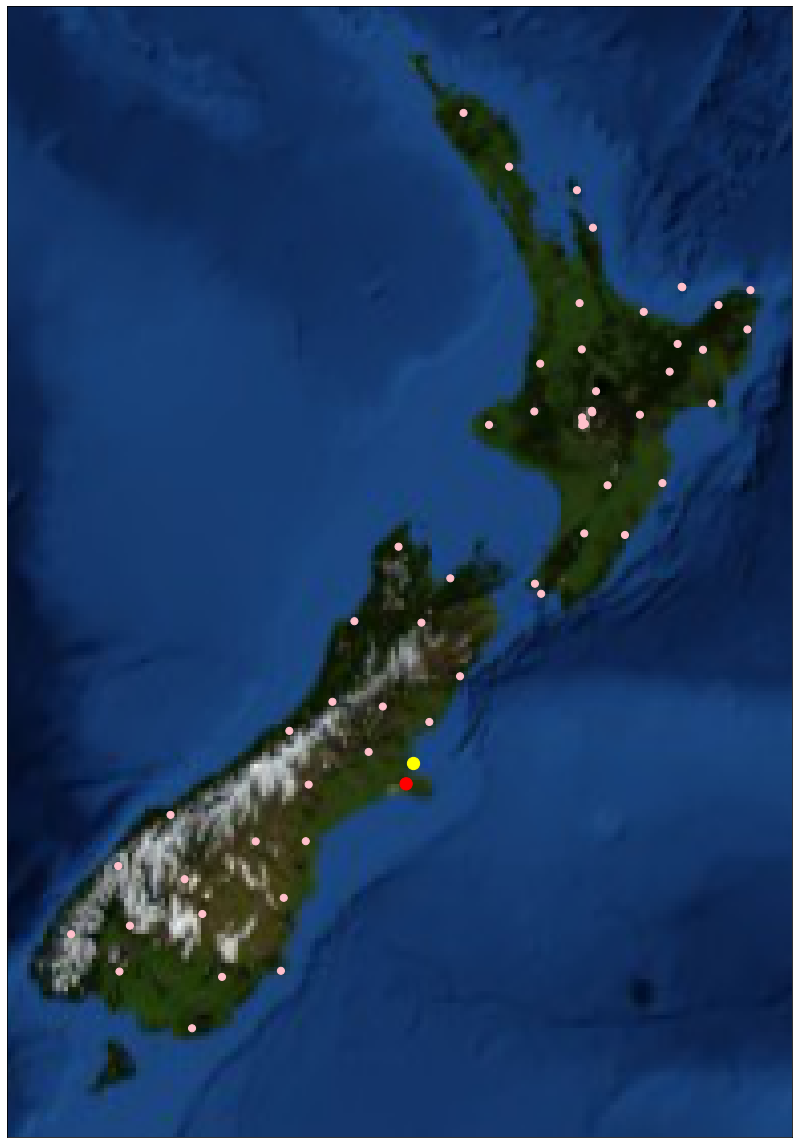

In [82]:
quake_index = 17408# random.randint(0, magn_distance_filtered_quakes_df.shape[0])
quake_label = magn_distance_filtered_quakes_df.label.astype(int).values[quake_index]

plt.figure(figsize=(16, 16))

sensors_latitudes=list(stations_in_bbox_df.latitude.values)
sensors_longitudes=list(stations_in_bbox_df.longitude.values)
   
colors = ['pink' for _ in range(len(sensors_latitudes))]
colors[quake_label] = "red"
sizes = [50 for _ in range(len(sensors_latitudes))]
sizes[quake_label] = 150
visualize_quakes(sensors_longitudes, sensors_latitudes, nz_basemap, sizes, colors, alpha=1, title="")


quakes_latitudes=list(magn_distance_filtered_quakes_df['latitude'].astype(float).values)
quakes_longitudes=list(magn_distance_filtered_quakes_df['longitude'].astype(float).values)
mapped_quakes_x,mapped_quakes_y=nz_basemap(quakes_longitudes,quakes_latitudes)
quakes_graph=nx.Graph()
quakes_graph.add_edge(quake_index, quake_index)
quakes_positions = {}
quakes_positions[quake_index]=(mapped_quakes_x[quake_index],mapped_quakes_y[quake_index])
nx.draw_networkx(quakes_graph,quakes_positions,node_size=150,node_color='yellow', with_labels=False, alpha=1)

# plt.title(f"Earthquake {quake_index} (yellow) is assigned to station {quake_label} (red). Other stations are in pink.")

nz_basemap.bluemarble()
plt.tight_layout()

# plt.savefig(os.path.join(image_folder, f"assigned_station_for_quake_{quake_index}.pdf"))

plt.show()

### Check which labels did not receive any earthquake

The following sensors did not receive any earthquake as a label: [32]


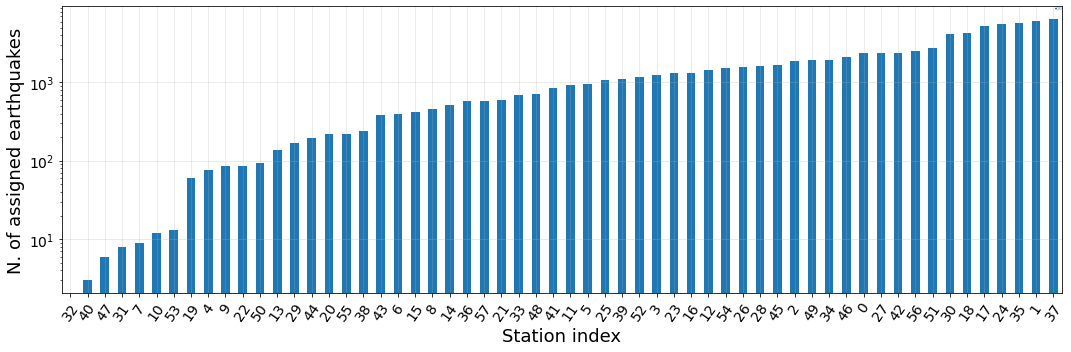

In [72]:
count_df = magn_distance_filtered_quakes_df.groupby('label').size()
missing_labels = []
for i in range(len(station_coordinates)):
    if i not in magn_distance_filtered_quakes_df.label.values:
        missing_labels.append(i)
        count_df.loc[i] = 0
print(f"The following sensors did not receive any earthquake as a label: {missing_labels}") 

count_df = count_df.reset_index(name='counts')
count_df['label'] = count_df['label'].astype(int)
count_df.sort_values('counts').plot.bar(x='label', y='counts', rot=55, figsize=(15, 5))
plt.yscale("log")
plt.xlabel("Station index", fontsize=18)
plt.ylabel("N. of assigned earthquakes", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.legend(fontsize=0)

plt.savefig(os.path.join(image_folder, f"labels_distribution_raw.pdf"))

plt.show()

# c = Counter(magn_distance_filtered_quakes_df.label.astype(int).values)
# print("From higher to lower:")
# print(c.most_common(100))

----------------

----------------

----------------

## Filtering earthquakes to obtain a balanced dataset

In [45]:
minimum_number_of_quakes_per_station = 150

In [46]:
filtered_quakes_df = magn_distance_filtered_quakes_df

In [47]:
count_df = filtered_quakes_df.groupby('label').size()
final_sensors = list(count_df[(count_df>minimum_number_of_quakes_per_station)].index)
print(f"Found {len(final_sensors)} stations with at least {minimum_number_of_quakes_per_station} quakes each. Total number of stations: {stations_in_bbox_df.shape[0]}.")

Found 45 stations with at least 150 quakes each. Total number of stations: 58.


In [48]:
final_quakes_df = filtered_quakes_df[
    (filtered_quakes_df['label'].isin(final_sensors))
]

resulting_unique_labels = np.unique(final_quakes_df.label.values)

print(f"With these filters you would obtain a total of {final_quakes_df.shape[0]} samples out of {len(all_quakes_dictionaries)}.")
print(f"If you want a COMPLETELY BALANCED dataset, you would obtain {minimum_number_of_quakes_per_station * len(resulting_unique_labels)} samples, distributed across {len(resulting_unique_labels)} stations ({minimum_number_of_quakes_per_station} per station)")
final_quakes_df.head(2)


With these filters you would obtain a total of 81904 samples out of 94098.
If you want a COMPLETELY BALANCED dataset, you would obtain 6750 samples, distributed across 45 stations (150 per station)


#eventid                 time  latitude  longitude  depth/km author  \
0  2016p139705  2016-02-21T16:34:54   -41.595    174.316      15.1    GNS   
1  2016p139326  2016-02-21T13:13:27   -38.419    176.516     120.3    GNS   

  catalog contributor contributorid magtype  magnitude magauthor  \
0     GNS         GNS   2016p139705       M        2.0       GNS   
1     GNS         GNS   2016p139326       M        1.8       GNS   

        eventlocationname  label  min_distance  
0    20 km east of Seddon    1.0     50.679402  
1  15 km west of Murupara   39.0     45.938905

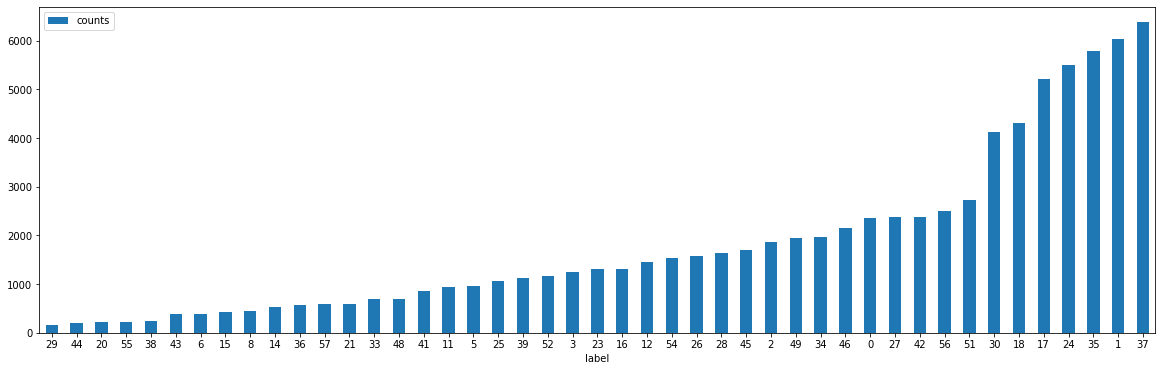

In [49]:
count_df = final_quakes_df.groupby('label').size()
       
count_df = count_df.reset_index(name='counts')
count_df['label'] = count_df['label'].astype(int)
count_df.sort_values('counts').plot.bar(x='label', y='counts', rot=0, figsize=(20, 6))
plt.show()

--------------------------

--------------------------

--------------------------

# Let's balance the data among the available classes

If we want to make it balanced we need to randomly subsample data from the classes with more samples.

In [50]:
min_available_training_per_class = count_df.counts.min()
ADDITIONAL_DATA = 5 # TO ACCOUNT FOR FAILING QUERIES

grouped = final_quakes_df.groupby('label')

final_quakes_idxs_balanced = []
for label, group in grouped:
    quake_idxs_in_group = list(group['#eventid'].values)
    if len(quake_idxs_in_group) >= min_available_training_per_class + ADDITIONAL_DATA:        
        selected_idxs = random.sample(quake_idxs_in_group, min_available_training_per_class + ADDITIONAL_DATA)
    else:
        selected_idxs = random.sample(quake_idxs_in_group, min_available_training_per_class)
        
    print(f"Label {label} --> {len(selected_idxs)} samples sampled.")
    final_quakes_idxs_balanced += selected_idxs

print(f"The balanced dataset (across {len(resulting_unique_labels)} classes) has {len(final_quakes_idxs_balanced)} samples (at least {min_available_training_per_class} per class)")

final_quakes_df_balanced = final_quakes_df[final_quakes_df['#eventid'].isin(final_quakes_idxs_balanced)]
final_quakes_df_balanced.shape

Label 0.0 --> 175 samples sampled.
Label 1.0 --> 175 samples sampled.
Label 2.0 --> 175 samples sampled.
Label 3.0 --> 175 samples sampled.
Label 5.0 --> 175 samples sampled.
Label 6.0 --> 175 samples sampled.
Label 8.0 --> 175 samples sampled.
Label 11.0 --> 175 samples sampled.
Label 12.0 --> 175 samples sampled.
Label 14.0 --> 175 samples sampled.
Label 15.0 --> 175 samples sampled.
Label 16.0 --> 175 samples sampled.
Label 17.0 --> 175 samples sampled.
Label 18.0 --> 175 samples sampled.
Label 20.0 --> 175 samples sampled.
Label 21.0 --> 175 samples sampled.
Label 23.0 --> 175 samples sampled.
Label 24.0 --> 175 samples sampled.
Label 25.0 --> 175 samples sampled.
Label 26.0 --> 175 samples sampled.
Label 27.0 --> 175 samples sampled.
Label 28.0 --> 175 samples sampled.
Label 29.0 --> 170 samples sampled.
Label 30.0 --> 175 samples sampled.
Label 33.0 --> 175 samples sampled.
Label 34.0 --> 175 samples sampled.
Label 35.0 --> 175 samples sampled.
Label 36.0 --> 175 samples sampled.

(7870, 15)

--------------------------

--------------------------

--------------------------

# Visualization of final balanced dataset

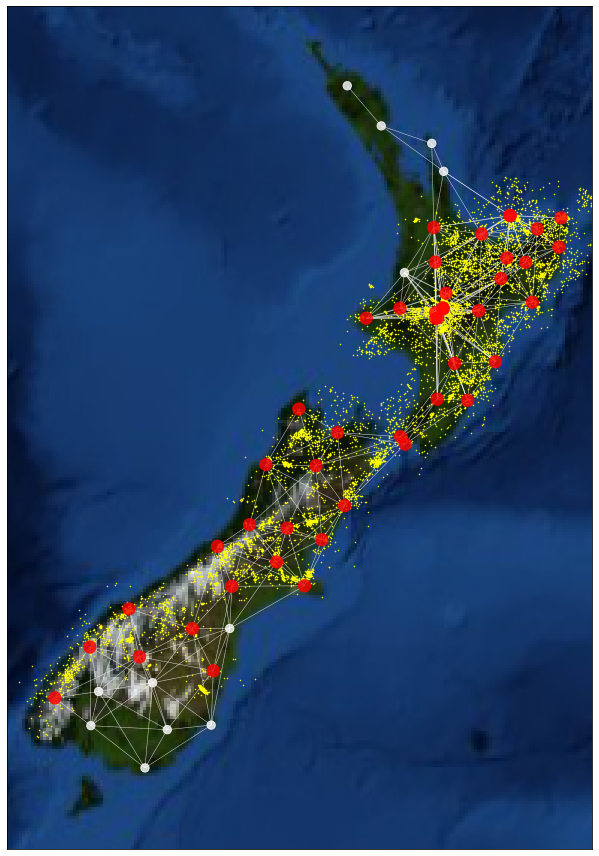

In [83]:
plt.figure(figsize=(12, 12))

quakes_latitudes=list(final_quakes_df_balanced['latitude'].astype(float).values)
quakes_longitudes=list(final_quakes_df_balanced['longitude'].astype(float).values)
visualize_quakes(quakes_longitudes, quakes_latitudes, nz_basemap, nodesize=0.3, nodecolor="yellow", alpha=1, title="")

sensors_latitudes=list(stations_in_bbox_df.latitude.values)
sensors_longitudes=list(stations_in_bbox_df.longitude.values)
   
station_colors = []
station_sizes = []
for station_idx in range(len(sensors_latitudes)):
    if station_idx in resulting_unique_labels:
        station_colors.append('red')
        station_sizes.append(150)
    else:
        station_colors.append('white')
        station_sizes.append(70)
    
visualize_sensors_graph(station_lons, station_lats, adjacency, 
                        nz_basemap, nodesize=station_sizes, nodecolor=station_colors, 
                        draw_edges=True, edgecolors='white', with_labels=False,
                       alpha=0.8)

title = f"{final_quakes_df_balanced.shape[0]} final balanced quakes (yellow). Stations with at least {min_available_training_per_class} earthquakes assigned are depicted in red, the remaining stations in white."
# plt.title(title)
nz_basemap.bluemarble()


plt.tight_layout()

plt.savefig(os.path.join(image_folder, f"quakes_summary.pdf"))

plt.show()

--------------------------

--------------------------

--------------------------

## Save and export everything. The crawling will be done with a normal python script (data_crawling.py).

In [52]:
# print(quakes_df.shape)
# print(final_quakes_df.shape)
# print(final_quakes_df_balanced.shape)
# print(stations_in_bbox.shape)

# quakes_df.to_csv(os.path.join(NEW_DATASET_FOLDER, "quakes_metadata_in_bbox.csv"), index=False)
# final_quakes_df.to_csv(os.path.join(NEW_DATASET_FOLDER, "final_quakes_in_bbox.csv"), index=False)
# final_quakes_df_balanced.to_csv(os.path.join(NEW_DATASET_FOLDER, "final_quakes_in_bbox_balanced.csv"), index=False)
# stations_in_bbox_df.to_csv(os.path.join(NEW_DATASET_FOLDER, "stations_in_bbox.csv"), index=False)

# bbox_dict = {
#     'bbox': bounding_box,
#     'description': "left lower corner longitude, upper right corner longitude, left lower corner latitude, upper right corner latitude"
# }
# write_pickle(bbox_dict, os.path.join(NEW_DATASET_FOLDER, "bbox_info.pickle"))

--------------------------

--------------------------

--------------------------